In [1]:
import warnings
warnings.filterwarnings('ignore')

import multiprocessing
n_cores = multiprocessing.cpu_count()

import sys
import os
import copy 

sys.path.insert(1, os.path.realpath(os.path.pardir))
sys.path.append("../node2vec2rank/")


import pandas as pd
import numpy as np

In [2]:
## experiment info that will be used for folder names and printing

tissue = 'BRCA'
target = 'nVSluma'
network_inf_method = 'PANDA'
gsea_exp_parent_folder_name = 'PANDA_BRCA_lumaVSadja'
save_gsea_results_notes = ''

In [3]:
# read the configuration file and the data
from node2vec2rank.dataloader import DataLoader
import json

config = json.load(open('../configs/config_panda_BRCA_LUMA_nt.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}

dataloader = DataLoader(config)

There are 997 row nodes and 25410 column nodes in graph 1
There are 997 row nodes and 25410 column nodes in graph 2
Graphs are rectangular


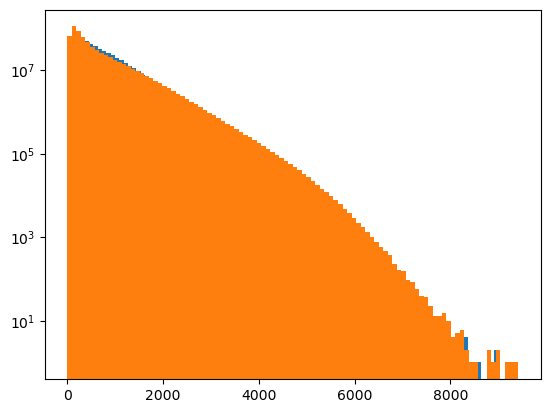

In [4]:
#plot the edge value histograms

from node2vec2rank.preprocessing_utils import network_transform
import matplotlib.pyplot as plt


first_flat = network_transform(dataloader.graphs[0].to_numpy(),threshold=0, project_unipartite_on='columns').flatten()
second_flat = network_transform(dataloader.graphs[1].to_numpy(),threshold=0,project_unipartite_on='columns').flatten()

plt.hist(first_flat,log=True,bins=100);
plt.hist(second_flat,log=True,bins=100);

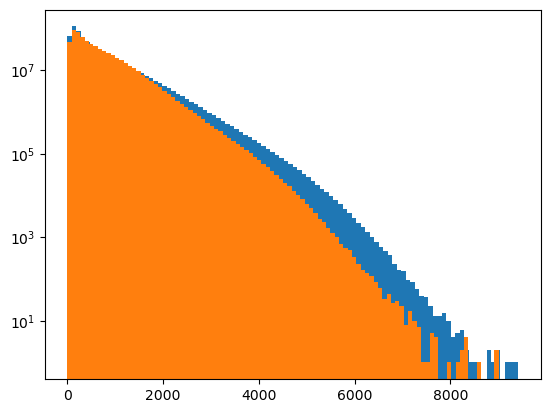

In [5]:
plt.hist(second_flat,log=True,bins=100);
plt.hist(first_flat,log=True,bins=100);

In [6]:
del first_flat, second_flat

In [7]:
#run n2v2r

from node2vec2rank.model import N2V2R

model = N2V2R(graphs=dataloader.graphs, config=config, node_names=dataloader.interest_nodes)
rankings = model.fit_transform_rank()

DeDi_ranking = model.degree_difference_ranking(threshold=0)
borda_rankings = model.aggregate_transform()

signed_rankings = model.signed_ranks_transform()

../output/10_28_2023_11_34_44

Running n2v2r with dimensions [4, 8, 12, 16, 20] and distance metrics ['euclidean', 'cosine'] ...
	UASE embedding in 183.34 seconds for bin=False and keep_top=100%
		Ranking in 4.95 seconds
n2v2r computed 10 rankings for 1 comparison(s) in 309.69 seconds

Rank aggregation with Borda ...
	Finished aggregation in 6.11 seconds

Signed ranks transformation ...
	Finished signed transformation in 2.63 seconds


In [8]:
##get the rankings of the comparison and map the ens to symbols

comparison = '1'
n2v2r_ranking_pd = rankings[comparison].copy()
n2v2r_borda_ranking_pd = borda_rankings[comparison].copy()
n2v2r_DeDi_ranking_pd = signed_rankings[comparison].copy()
n2v2r_borda_DeDi_ranking_pd = model.pairwise_signed_aggregate_ranks[comparison].copy()
DeDi_ranking_pd = DeDi_ranking[comparison].copy()

gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
genes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in dataloader.interest_nodes ]

n2v2r_ranking_pd.index = genes_mapped
n2v2r_borda_ranking_pd.index = genes_mapped
n2v2r_DeDi_ranking_pd.index = genes_mapped
n2v2r_borda_DeDi_ranking_pd.index = genes_mapped
DeDi_ranking_pd.index = genes_mapped


In [9]:
# run overrepresentation analysis 
from node2vec2rank.post_utils import enrichr_gseapy, read_gmt
from itertools import chain
import os

save_results = True
do_kegg = True
do_gobp = True
do_reac = True
do_immune = True



# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'
reac_pathway_fn = '../data/gene_set_libraries/human/c2.cp.reactome.v7.5.1.symbols.gmt'
immune_pathway_fn = '../data/gene_set_libraries/human/c7.immunesigdb.v7.5.1.symbols.gmt'



# network_background or pathway_background for enrichment
# network will use the genes in the network only, while pathway will use all the genes in the pathways
# network is "more fair" but will find less things in small networks
background = 'network_background'
organism = 'human'

# take the top k percentage of the ranking for enrichment
top_k_percent = 5

if background == 'network_background':
    kegg_background = n2v2r_ranking_pd.index.to_list()
    gobp_background = n2v2r_ranking_pd.index.to_list()
    reac_background = n2v2r_ranking_pd.index.to_list()
    immune_background = n2v2r_ranking_pd.index.to_list()
elif background == 'pathway_background':
    kegg_dict = read_gmt(kegg_pathway_fn)
    kegg_background = list(set(chain.from_iterable(kegg_dict.values())))
    gobp_dict = read_gmt(gobp_pathway_fn)
    gobp_background = list(set(chain.from_iterable(gobp_dict.values())))
    reac_dict = read_gmt(reac_pathway_fn)
    reac_background = list(set(chain.from_iterable(reac_dict.values())))
    immune_dict = read_gmt(immune_pathway_fn)
    immune_background = list(set(chain.from_iterable(immune_dict.values())))
else:
    raise Exception("Enrichment background not properly set")


if do_kegg:
    n2v2r_consensus_ORA_KEGG_pd = enrichr_gseapy(n2v2r_ranking_pd, kegg_pathway_fn, background=kegg_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_KEGG_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_KEGG_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if do_gobp:
    n2v2r_consensus_ORA_GOBP_pd = enrichr_gseapy(n2v2r_ranking_pd, gobp_pathway_fn, background=gobp_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_GOBP_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_GOBP_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if do_reac:
    n2v2r_consensus_ORA_REAC_pd = enrichr_gseapy(n2v2r_ranking_pd, reac_pathway_fn, background=reac_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_REAC_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, reac_pathway_fn, background=reac_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_REAC_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], reac_pathway_fn, background=reac_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if do_immune:
    n2v2r_consensus_ORA_IMMUNE_pd = enrichr_gseapy(n2v2r_ranking_pd, immune_pathway_fn, background=immune_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_IMMUNE_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, immune_pathway_fn, background=immune_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_IMMUNE_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], immune_pathway_fn, background=immune_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)


if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    if do_kegg:
        n2v2r_consensus_ORA_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                       "_n2v2r"+"_consensus_ORA_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r_borda_ORA_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_ORA_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_ORA_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_gobp:
        n2v2r_consensus_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                       "_n2v2r"+"_consensus_ORA_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                             "_n2v2r_borda_ORA_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_ORA_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_reac:
        n2v2r_consensus_ORA_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                        "_n2v2r"+"_consensus_ORA_REAC_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                                "_n2v2r_borda_ORA_REAC_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')                        
        absDeDi_ORA_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_absDeDi"+"_ORA_REAC_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_immune:
        n2v2r_consensus_ORA_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                        "_n2v2r"+"_consensus_ORA_IMMUNE_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                                "_n2v2r_borda_ORA_IMMUNE_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')                        
        absDeDi_ORA_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_absDeDi"+"_ORA_IMMUNE_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')



In [33]:
from node2vec2rank.post_utils import plot_gseapy_enrich 

stability_cutoff = 0.2
padj_cutoff = 0.1


save_directory = '../results/results_gsea/' + gsea_exp_parent_folder_name
# save_directory = None

if do_kegg:
    title = network_inf_method+ " " +  tissue +  " KEGG ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    plot_gseapy_enrich(n2v2r_consensus_ORA_KEGG_pd, has_stability=True, trim_first_num_characters=5, characters_trim=70, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory)
    plot_gseapy_enrich(n2v2r_borda_ORA_KEGG_pd, padj_cutoff=padj_cutoff,characters_trim=70, trim_first_num_characters=5,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory)
    plot_gseapy_enrich(absDeDi_ORA_KEGG_pd, padj_cutoff=padj_cutoff,characters_trim=70,trim_first_num_characters=5, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory)


if do_gobp:
    title = network_inf_method+ " " +  tissue +  " GOBP ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    plot_gseapy_enrich(n2v2r_consensus_ORA_GOBP_pd, has_stability=True, characters_trim=70,trim_first_num_characters=5,padj_cutoff=padj_cutoff,stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory)
    plot_gseapy_enrich(n2v2r_borda_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=70,trim_first_num_characters=5,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory)
    plot_gseapy_enrich(absDeDi_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=70, trim_first_num_characters=5,has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory)

if do_reac:
    title = network_inf_method+ " " +  tissue +  " REAC ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    plot_gseapy_enrich(n2v2r_consensus_ORA_REAC_pd, has_stability=True, characters_trim=70,trim_first_num_characters=9,padj_cutoff=padj_cutoff,stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory)
    plot_gseapy_enrich(n2v2r_borda_ORA_REAC_pd, padj_cutoff=padj_cutoff,characters_trim=70,trim_first_num_characters=9,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory)
    plot_gseapy_enrich(absDeDi_ORA_REAC_pd, padj_cutoff=padj_cutoff,characters_trim=70, trim_first_num_characters=9,has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory)

if do_immune:

    title = network_inf_method+ " " +  tissue +  " IMMUNE ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    plot_gseapy_enrich(n2v2r_consensus_ORA_IMMUNE_pd, has_stability=True, characters_trim=70,trim_first_num_characters=9,padj_cutoff=padj_cutoff,stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory)
    plot_gseapy_enrich(n2v2r_borda_ORA_IMMUNE_pd, padj_cutoff=padj_cutoff,characters_trim=70,trim_first_num_characters=9,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory)
    plot_gseapy_enrich(absDeDi_ORA_IMMUNE_pd, padj_cutoff=padj_cutoff,characters_trim=70,trim_first_num_characters=9, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory)



In [34]:
# run prerank GSEA
from node2vec2rank.post_utils import prerank_gseapy

save_results = True
do_kegg = True
do_gobp = True
do_reac = True
do_immune = True



# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'
reac_pathway_fn = '../data/gene_set_libraries/human/c2.cp.reactome.v7.5.1.symbols.gmt'
immune_pathway_fn = '../data/gene_set_libraries/human/c7.immunesigdb.v7.5.1.symbols.gmt'


prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1500


if do_kegg:
    n2v2r_consensus_pre_KEGG_pd = prerank_gseapy(n2v2r_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_KEGG_pd = prerank_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_KEGG_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], kegg_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_gobp:
    n2v2r_consensus_pre_GOBP_pd = prerank_gseapy(n2v2r_ranking_pd, gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_GOBP_pd = prerank_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_GOBP_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], gobp_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_reac:
    n2v2r_consensus_pre_REAC_pd = prerank_gseapy(n2v2r_ranking_pd, reac_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_REAC_pd = prerank_gseapy(n2v2r_borda_ranking_pd, reac_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_REAC_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], reac_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_immune:
    n2v2r_consensus_pre_IMMUNE_pd = prerank_gseapy(n2v2r_ranking_pd, immune_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_IMMUNE_pd = prerank_gseapy(n2v2r_borda_ranking_pd, immune_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_IMMUNE_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], immune_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)


    if do_kegg:
        n2v2r_consensus_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_n2v2r"+"_consensus_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
        n2v2r_borda_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
        absDeDi_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

    if do_gobp:
        n2v2r_consensus_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_reac:
        n2v2r_consensus_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        

    if do_immune:
        n2v2r_consensus_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')


    
   

2023-10-28 12:01:39,958 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-10-28 12:01:39,967 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-28 12:01:43,788 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-10-28 12:01:43,796 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-28 12:01:47,200 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-10-28 12:01:47,207 [WARNING] Duplicated values found in preranked stats: 0.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-10-28 12:01:50,517 [WARNING] Input gene rankings contains duplicated IDs, Only use the dupli

In [36]:
from node2vec2rank.post_utils import plot_gseapy_prerank 

stability_cutoff = 0.2
padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_exp_parent_folder_name

if do_kegg:
    title = network_inf_method+ " " +  tissue +  " KEGG prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(n2v2r_consensus_pre_KEGG_pd, has_stability=True, characters_trim=70, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory)
    plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False, characters_trim=70,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory)
    plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=70,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory)

if do_gobp:
    title = network_inf_method+ " " +  tissue +  " GOBP prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(n2v2r_consensus_pre_GOBP_pd, has_stability=True, characters_trim=70, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory)
    plot_gseapy_prerank(n2v2r_borda_pre_GOBP_pd, has_stability=False, characters_trim=70, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory)
    plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=70, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory)

if do_reac:
    title = network_inf_method+ " " +  tissue +  " REAC prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(n2v2r_consensus_pre_REAC_pd, has_stability=True, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory)
    plot_gseapy_prerank(n2v2r_borda_pre_REAC_pd, has_stability=False, characters_trim=70, trim_first_num_characters=9,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory)
    plot_gseapy_prerank(absDeDi_pre_REAC_pd, has_stability=False, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory)

if do_immune:
    title = network_inf_method+ " " +  tissue +  " IMMUNE prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(n2v2r_consensus_pre_IMMUNE_pd, has_stability=True, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory)
    plot_gseapy_prerank(n2v2r_borda_pre_IMMUNE_pd, has_stability=False, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory)
    plot_gseapy_prerank(absDeDi_pre_IMMUNE_pd, has_stability=False, characters_trim=70,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory)

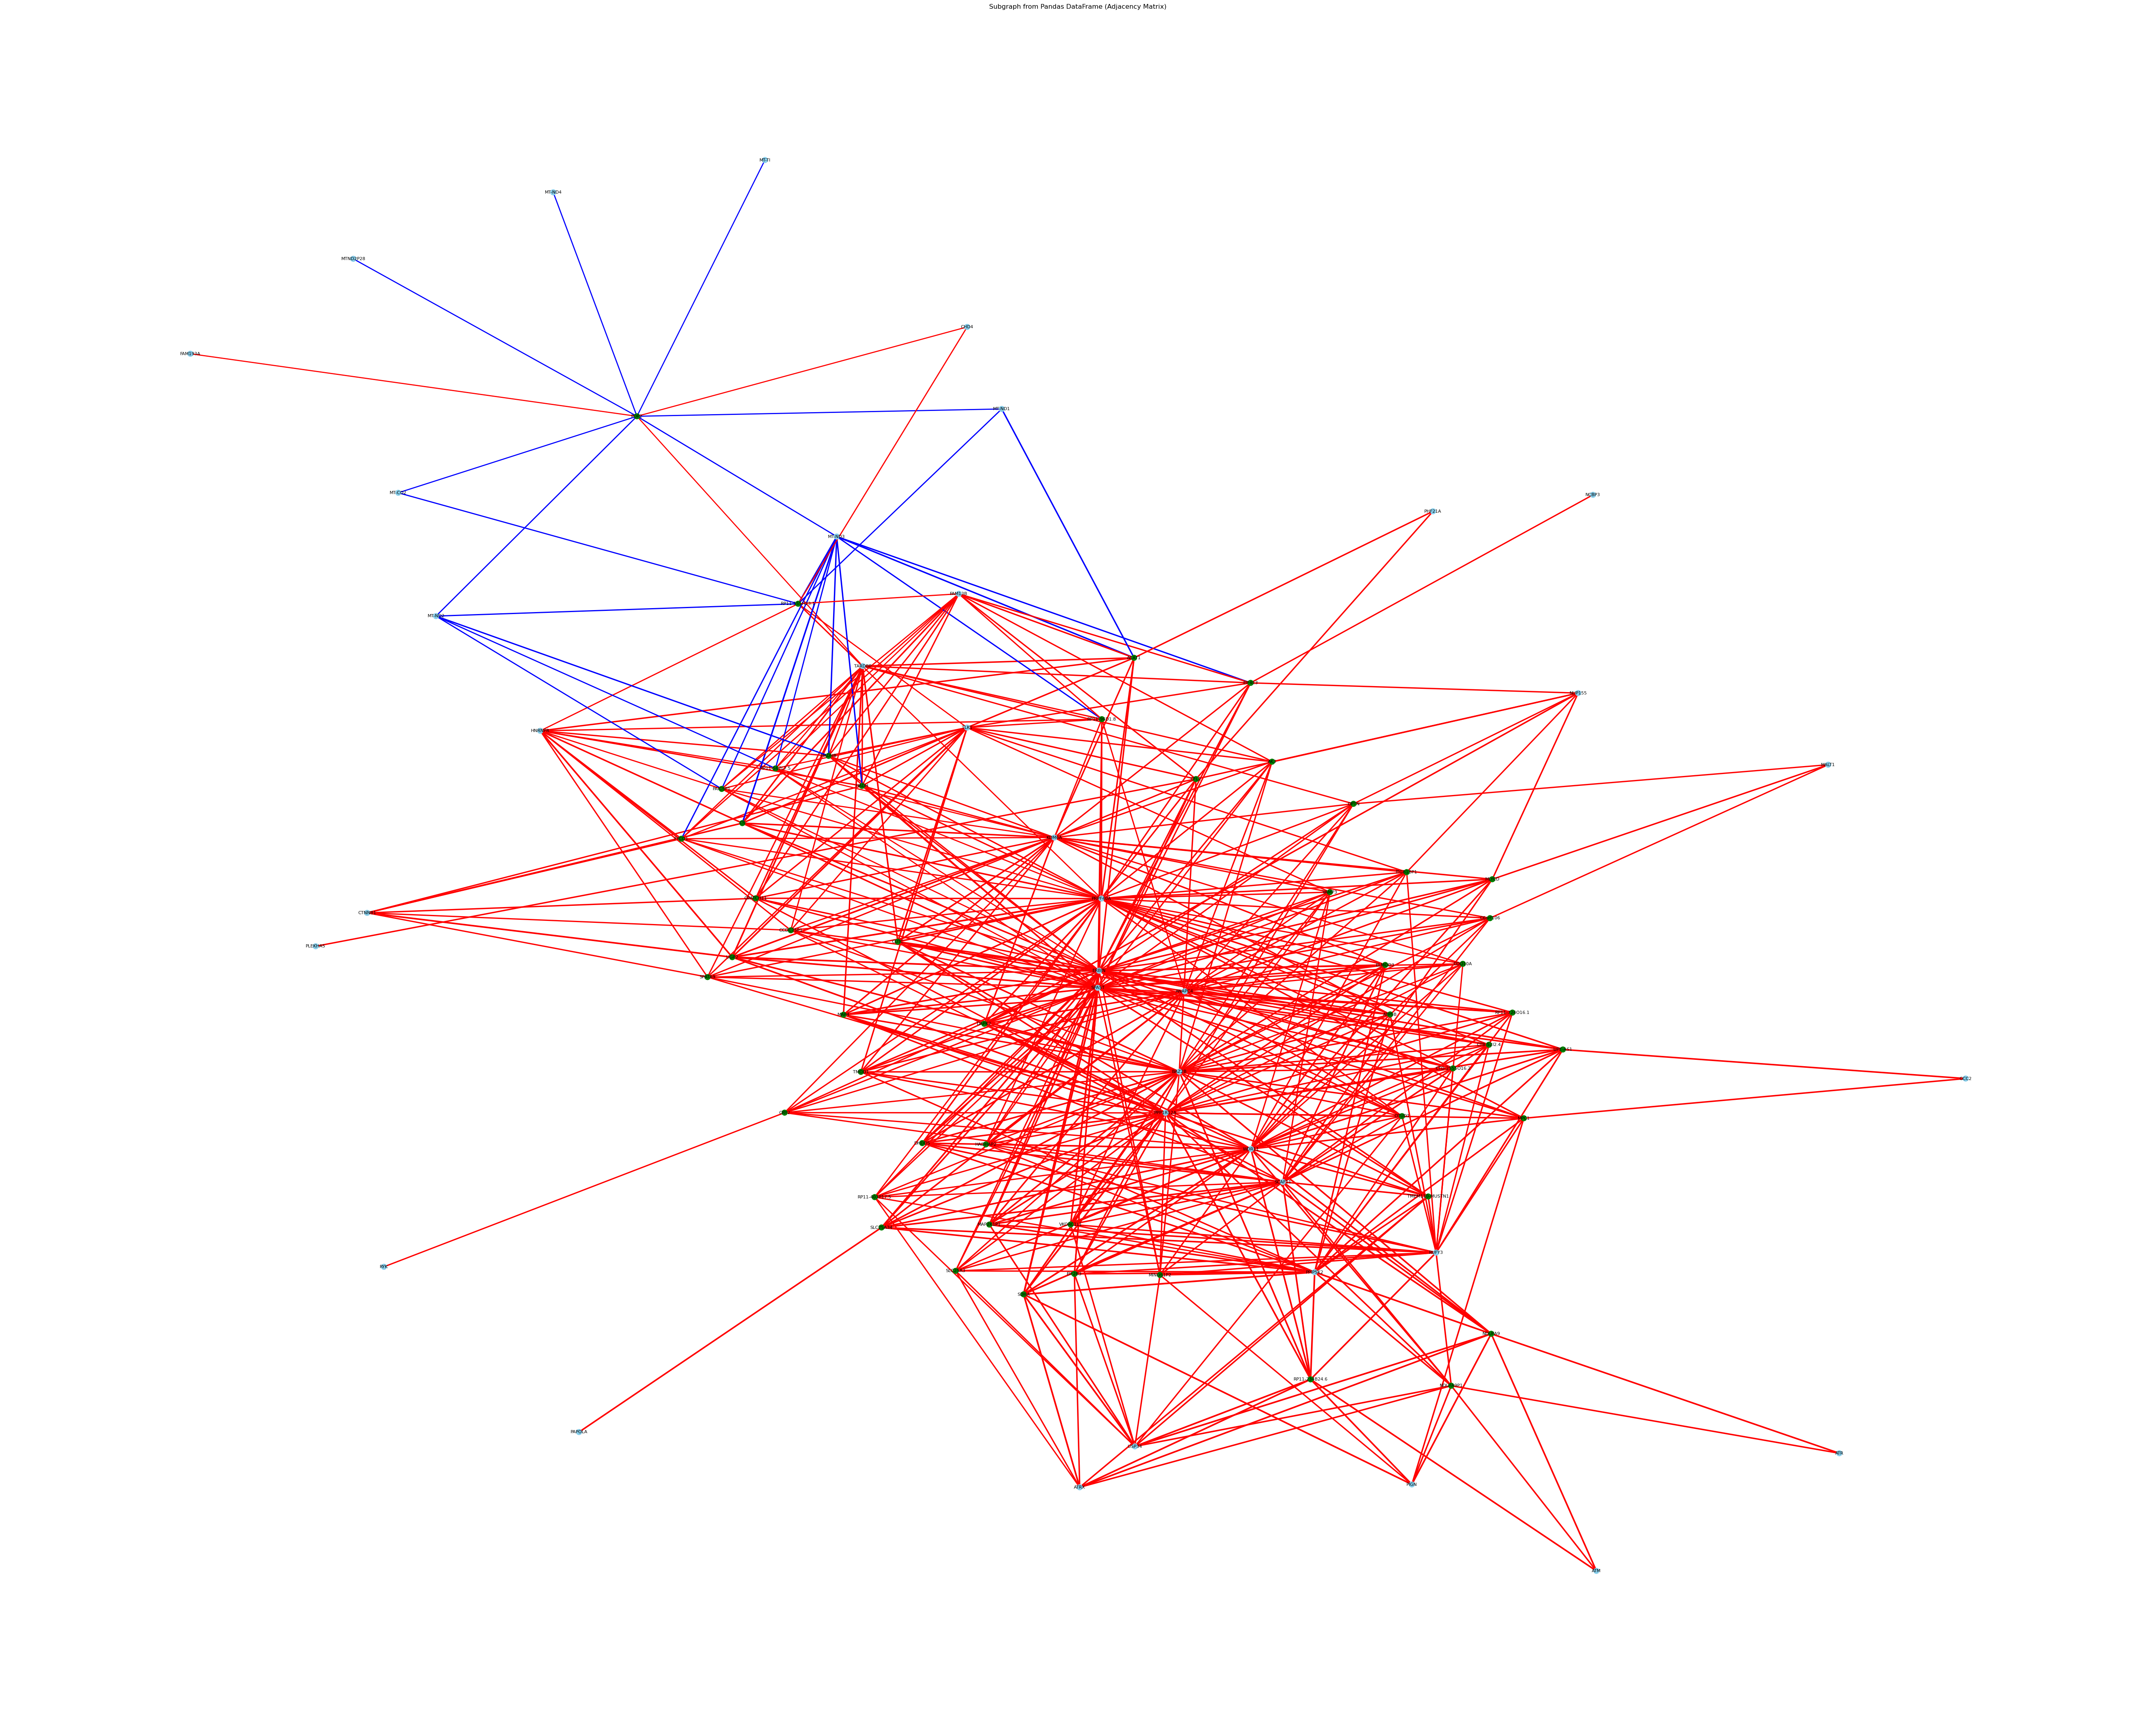

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
from node2vec2rank.preprocessing_utils import network_transform, bipartite_to_unipartite_projection

num_nodes_to_check = 50

net_one = dataloader.graphs[0]
net_two= dataloader.graphs[1]

net_one = bipartite_to_unipartite_projection(net_one,project_unipartite_on="columns")
net_two = bipartite_to_unipartite_projection(net_two,project_unipartite_on="columns")


dif_net = net_one-net_two
n2v2r_borda_ranking_pd = borda_rankings[comparison].copy()
n2v2r_borda_ranking_pd.sort_values(by='borda_ranks',ascending=False, inplace=True)
specific_nodes = n2v2r_borda_ranking_pd.index[:num_nodes_to_check].to_list()
specific_nodes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in specific_nodes]
dif_net.index = dataloader.get_interest_nodes()
dif_net.columns = dataloader.get_interest_nodes()



subgraph_pd = dif_net.loc[:,specific_nodes]


gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
subgraph_pd.index = [ens2symbol[x] if x in ens2symbol else x for x in subgraph_pd.index ]
subgraph_pd.columns = [ens2symbol[x] if x in ens2symbol else x for x in subgraph_pd.columns ]


# Convert the adjacency matrix to an edge list
edge_list = subgraph_pd.T.stack().reset_index()
edge_list.columns = ['Source', 'Target', 'Weight']

# Filtering out the diagonal elements
edge_list = edge_list[edge_list['Source'] != edge_list['Target']]

edge_list['abs_value'] = edge_list['Weight'].abs()

edge_list = edge_list[edge_list.abs_value!=0]

# Sort the DataFrame by the absolute values, then keep the top 100
edge_list_red = edge_list.sort_values(by='abs_value', ascending=False).groupby('Source').head(10)
# edge_list_red = edge_list.sort_values(by='abs_value', ascending=False).head(2000)

# edge_list_red = edge_list_red.drop(columns=['abs_value'])



G = nx.from_pandas_edgelist(edge_list_red, source='Source', target='Target', edge_attr=True)


fig, ax = plt.subplots(figsize=(70, 56))  # You can adjust the width and height as needed

# Draw the subgraph using NetworkX
# pos = nx.kamada_kawai_layout(G)
min_weight = edge_list['Weight'].abs().min()
max_weight = edge_list['Weight'].abs().max()

edge_weights = [3.0*(np.abs(G[u][v]['Weight']) - min_weight)/(max_weight-min_weight) for u, v in G.edges]
edge_colors = ['red' if G[u][v]['Weight'] < 0 else 'blue' for u, v in G.edges]

node_colors = ['green' if node in specific_nodes_mapped else 'skyblue'  for node in G.nodes]

nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), with_labels=True, node_size=100, node_color=node_colors, edge_color=edge_colors, width=edge_weights, ax=ax,font_size=8)

plt.title("Subgraph from Pandas DataFrame (Adjacency Matrix)")
plt.show()
